# XGBoost

In this notebook, the prepared Dataset is loaded and an XGBoost Model is fitted

In [1]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error, mean_squared_error
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import pickle

# General Functions

In [2]:
def evaluate_forecast(y_true, y_pred, model_name="Model"):
    """
    Evaluate forecast predictions using MSE, MAE, and R².

    Args:
        y_true (array-like): Actual values
        y_pred (array-like): Forecasted values
        model_name (str): Optional name of the model (for print output)
    """
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"{model_name} Evaluation:")
    print(f"  MSE      : {mse:.2f}")
    print(f"  MAE      : {mae:.2f}")
    print(f"  R² Score : {r2:.4f}")
    
    return {"mse": mse, "mae": mae, "r2": r2}

In [3]:
# Load data
df_train = pd.read_csv('../data/train_modelling.csv')

df_train.head()

,Unnamed: 0,store_nbr,item_nbr,date,unit_sales,onpromotion,year,month,day,day_of_week,unit_sales_7d_avg,weekend,weekday,quarter,lag_1,lag_7,lag_14,rolling_mean_7,rolling_std_7
0,0,27,804974,2013-01-22,0.0,0,2013,1,22,1,0.714286,0,1,1,0.0,0.0,0.0,0.714286,1.889822
1,1,27,804974,2013-01-23,8.0,0,2013,1,23,2,1.142857,0,2,1,0.0,5.0,0.0,0.714286,1.889822
2,2,27,804974,2013-01-24,0.0,0,2013,1,24,3,1.142857,0,3,1,8.0,0.0,2.0,1.142857,3.023716
3,3,27,804974,2013-01-25,0.0,0,2013,1,25,4,1.142857,0,4,1,0.0,0.0,0.0,1.142857,3.023716
4,4,27,804974,2013-01-26,4.0,0,2013,1,26,5,1.714286,1,5,1,0.0,0.0,6.0,1.142857,3.023716


In [4]:
df_train.drop(columns='Unnamed: 0', inplace=True)
df_train.head()

,store_nbr,item_nbr,date,unit_sales,onpromotion,year,month,day,day_of_week,unit_sales_7d_avg,weekend,weekday,quarter,lag_1,lag_7,lag_14,rolling_mean_7,rolling_std_7
0,27,804974,2013-01-22,0.0,0,2013,1,22,1,0.714286,0,1,1,0.0,0.0,0.0,0.714286,1.889822
1,27,804974,2013-01-23,8.0,0,2013,1,23,2,1.142857,0,2,1,0.0,5.0,0.0,0.714286,1.889822
2,27,804974,2013-01-24,0.0,0,2013,1,24,3,1.142857,0,3,1,8.0,0.0,2.0,1.142857,3.023716
3,27,804974,2013-01-25,0.0,0,2013,1,25,4,1.142857,0,4,1,0.0,0.0,0.0,1.142857,3.023716
4,27,804974,2013-01-26,4.0,0,2013,1,26,5,1.714286,1,5,1,0.0,0.0,6.0,1.142857,3.023716


In [5]:
# Select necessary columns
features = ['weekday', 'weekend', 'lag_1', 'lag_7', 'rolling_mean_7', 'rolling_std_7', 'onpromotion']
target = 'unit_sales'

df_train_model = df_train.dropna(subset=features + [target])


In [6]:
df_train_model.head()

,store_nbr,item_nbr,date,unit_sales,onpromotion,year,month,day,day_of_week,unit_sales_7d_avg,weekend,weekday,quarter,lag_1,lag_7,lag_14,rolling_mean_7,rolling_std_7
0,27,804974,2013-01-22,0.0,0,2013,1,22,1,0.714286,0,1,1,0.0,0.0,0.0,0.714286,1.889822
1,27,804974,2013-01-23,8.0,0,2013,1,23,2,1.142857,0,2,1,0.0,5.0,0.0,0.714286,1.889822
2,27,804974,2013-01-24,0.0,0,2013,1,24,3,1.142857,0,3,1,8.0,0.0,2.0,1.142857,3.023716
3,27,804974,2013-01-25,0.0,0,2013,1,25,4,1.142857,0,4,1,0.0,0.0,0.0,1.142857,3.023716
4,27,804974,2013-01-26,4.0,0,2013,1,26,5,1.714286,1,5,1,0.0,0.0,6.0,1.142857,3.023716


In [7]:
df_test = pd.read_csv('../data/test_modelling.csv')
df_test.head()

,Unnamed: 0,store_nbr,item_nbr,date,unit_sales,onpromotion,year,month,day,day_of_week,unit_sales_7d_avg,weekend,weekday,quarter,lag_1,lag_7,lag_14,rolling_mean_7,rolling_std_7
0,344,27,804974,2014-01-01,0.0,0,2014,1,1,2,0.0,0,2,1,0.0,0.0,0.0,0.0,0.0
1,345,27,804974,2014-01-02,0.0,0,2014,1,2,3,0.0,0,3,1,0.0,0.0,0.0,0.0,0.0
2,346,27,804974,2014-01-03,0.0,0,2014,1,3,4,0.0,0,4,1,0.0,0.0,0.0,0.0,0.0
3,347,27,804974,2014-01-04,0.0,0,2014,1,4,5,0.0,1,5,1,0.0,0.0,0.0,0.0,0.0
4,348,27,804974,2014-01-05,0.0,0,2014,1,5,6,0.0,1,6,1,0.0,0.0,0.0,0.0,0.0


In [8]:
df_test.drop(columns='Unnamed: 0', inplace=True)
df_test.head()

,store_nbr,item_nbr,date,unit_sales,onpromotion,year,month,day,day_of_week,unit_sales_7d_avg,weekend,weekday,quarter,lag_1,lag_7,lag_14,rolling_mean_7,rolling_std_7
0,27,804974,2014-01-01,0.0,0,2014,1,1,2,0.0,0,2,1,0.0,0.0,0.0,0.0,0.0
1,27,804974,2014-01-02,0.0,0,2014,1,2,3,0.0,0,3,1,0.0,0.0,0.0,0.0,0.0
2,27,804974,2014-01-03,0.0,0,2014,1,3,4,0.0,0,4,1,0.0,0.0,0.0,0.0,0.0
3,27,804974,2014-01-04,0.0,0,2014,1,4,5,0.0,1,5,1,0.0,0.0,0.0,0.0,0.0
4,27,804974,2014-01-05,0.0,0,2014,1,5,6,0.0,1,6,1,0.0,0.0,0.0,0.0,0.0


In [9]:
# Add weekday column
df_test['weekend'] = df_test['weekday'] >= 5

df_test['weekend'] = df_test['weekday'].astype(int)

df_test.head(10)

,store_nbr,item_nbr,date,unit_sales,onpromotion,year,month,day,day_of_week,unit_sales_7d_avg,weekend,weekday,quarter,lag_1,lag_7,lag_14,rolling_mean_7,rolling_std_7
0,27,804974,2014-01-01,0.0,0,2014,1,1,2,0.000000,2,2,1,0.0,0.0,0.0,0.000000,0.000000
1,27,804974,2014-01-02,0.0,0,2014,1,2,3,0.000000,3,3,1,0.0,0.0,0.0,0.000000,0.000000
2,27,804974,2014-01-03,0.0,0,2014,1,3,4,0.000000,4,4,1,0.0,0.0,0.0,0.000000,0.000000
3,27,804974,2014-01-04,0.0,0,2014,1,4,5,0.000000,5,5,1,0.0,0.0,0.0,0.000000,0.000000
4,27,804974,2014-01-05,0.0,0,2014,1,5,6,0.000000,6,6,1,0.0,0.0,0.0,0.000000,0.000000
5,27,804974,2014-01-06,4.0,0,2014,1,6,0,0.571429,0,0,1,0.0,0.0,0.0,0.000000,0.000000
6,27,804974,2014-01-07,0.0,0,2014,1,7,1,0.571429,1,1,1,4.0,0.0,0.0,0.571429,1.511858
7,27,804974,2014-01-08,0.0,0,2014,1,8,2,0.571429,2,2,1,0.0,0.0,0.0,0.571429,1.511858
8,27,804974,2014-01-09,0.0,0,2014,1,9,3,0.571429,3,3,1,0.0,0.0,0.0,0.571429,1.511858
9,27,804974,2014-01-10,0.0,0,2014,1,10,4,0.571429,4,4,1,0.0,0.0,0.0,0.571429,1.511858


In [10]:
# Select necessary columns
features = ['weekday', 'weekend', 'lag_1', 'lag_7', 'rolling_mean_7', 'rolling_std_7', 'onpromotion']
target = 'unit_sales'

df_test_model = df_test.dropna(subset=features + [target])

In [11]:
# Create Train-Teat Split(Time Based)
X_train = df_train_model[features]
y_train = df_train_model[target]
X_test = df_test_model[features]
y_test = df_test_model[target]


In [12]:

model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.01,
    max_depth=5,
    subsample=0.6,
    colsample_bytree=0.6,
    min_child_weight=5,
    gamma=0.1,
    random_state=42
)

model.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.6
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


# Predict and Evaluate

In [13]:
#Fit and Evaluate with Test Data
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"XGBoost Forecasting Evaluation:")
print(f"  RMSE     : {rmse:.2f}")
print(f"  MAE      : {mae:.2f}")
print(f"  R² Score : {r2:.4f}")

XGBoost Forecasting Evaluation:
  RMSE     : 2.63
  MAE      : 0.41
  R² Score : 0.0211


# Plot Forecast and Actual

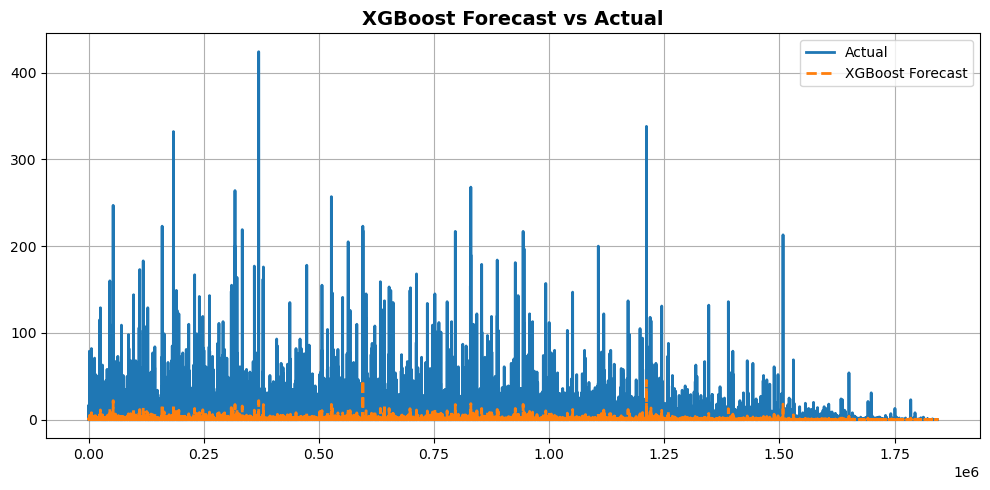

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test.values, label='Actual', linewidth=2)
plt.plot(y_test.index, y_pred, label='XGBoost Forecast', linestyle='--', linewidth=2)
plt.title('XGBoost Forecast vs Actual', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
# Evaluate Model Performance
y_pred = model.predict(X_test)

evaluate_forecast(y_test, y_pred, model_name="XGBoost")

XGBoost Evaluation:
  MSE      : 6.94
  MAE      : 0.41
  R² Score : 0.0211


{'mse': 6.939821407047367,
 'mae': 0.40513253080985595,
 'r2': 0.021090920142151304}

# Hyperparameter Tuning

In [16]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
}

search = RandomizedSearchCV(XGBRegressor(), param_grid, cv=3, n_iter=10, scoring='neg_mean_squared_error')
search.fit(X_train, y_train)

best_model = search.best_estimator_

print('Best Parameters:', search.best_params_)


Best Parameters: {'subsample': 1.0, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.6}


In [17]:
# Evaluate best model on test set
y_pred_best = best_model.predict(X_test)
evaluate_forecast(y_test, y_pred_best, model_name="Tuned XGBoost")

Tuned XGBoost Evaluation:
  MSE      : 6.95
  MAE      : 0.40
  R² Score : 0.0203


{'mse': 6.945297705760358,
 'mae': 0.40383652908144213,
 'r2': 0.02031845090703277}

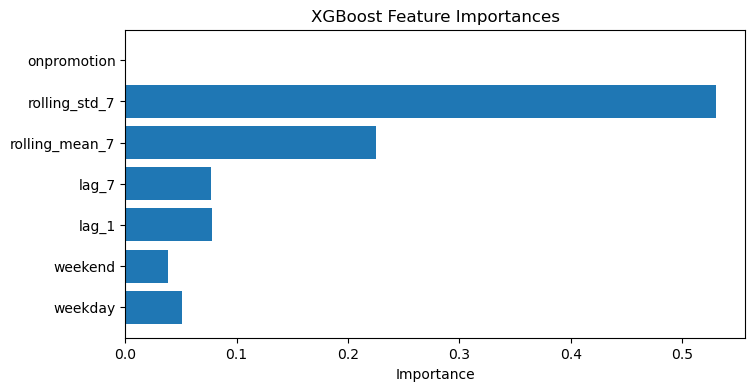

In [18]:
# Features Importance
plt.figure(figsize=(8, 4))
plt.barh(X_train.columns, best_model.feature_importances_)
plt.title("XGBoost Feature Importances")
plt.xlabel("Importance")
plt.show()

In [ ]:
# Save Best Model

In [19]:
# Best Model
# Save the model
with open("../model/xgboost_best_model_AA.pkl", "wb") as f:
    pickle.dump(best_model, f)